# Backgroud
We have achieved 0.89 classification F1-score in our [last notebook](https://github.com/Sylar257/Non-English-language-NLP/blob/master/Vietnamese%20Sentiment%20Analysis.ipynb) which is just a little shy of the best performing model of the [Vietnamese sentiment competition](https://www.aivivn.com/contests/1) top score (F1-score: 0.90).
This notebook follows similar training steps of the [last notebook](https://github.com/Sylar257/Non-English-language-NLP/blob/master/Vietnamese%20Sentiment%20Analysis.ipynb) but tries to build a **Backward** Vietnamese language model for classification.
The idea is, since our input data is not reading from streaming data, we have the freedom to read the text *forawrd* or *backward* resulting in different **feature extraction** for the language classifier. Hence, let's create a backward model and build an **ensemble model** for more robust performance.

In [1]:
%matplotlib inline

from fastai import *
from fastai.text import *

In [2]:
bs=48

In [3]:
Config.data_path()

PosixPath('/home/projectx/.fastai/data')

In [4]:
data_path = Path(os.getcwd())
data_path

PosixPath('/home/projectx/Documents/Non-English sentiment analysis')

In [5]:
# Same deal here, change the default data_path 
# and create all variable for model construct with `_bwd`
lang = 'vi'
name = f'{lang}wiki'
path = data_path/name
dest = path/'docs'
lm_fns = [f'{lang}_wt_bwd', f'{lang}_wt_vocab_bwd']

In [6]:
dest

PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/docs')

In [15]:
data = (TextList.from_folder(dest)
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()
            .databunch(bs=bs, backwards=True))

# data.save(f'{lang}_databunch_bwd')

In [16]:
data.show_batch

<bound method DataBunch.show_batch of TextLMDataBunch;

Train: LabelList (66149 items)
x: LMTextList
xxbos xxmaj thuyết hỗ sinh 
 
  xxmaj thuyết hỗ sinh hay thuyết tương sinh ( " xxmaj xxunk " ) là lý thuyết sinh học mô tả sự tương tác sinh thái giữa hai hoặc nhiều loài trong đó mỗi loài đều được hưởng lợi từ việc này . xxmaj thuyết hỗ sinh được cho là loại tương tác sinh thái phổ biến nhất và nó thường chiếm ưu thế trong hầu hết các cộng đồng trên toàn thế giới . xxmaj thuyết hỗ sinh có thể tương phản với cạnh tranh giữa các quan thể , giống loài , trong đó mỗi loài có kinh nghiệm trong việc tiến kiệm sức lực , năng lượng , và cùng khai thác tài nguyên , hoặc ký sinh trùng , trong đó một loài được hưởng lợi từ " " công sức " " của loài kia . 
  xxmaj thuật ngữ tương sinh đã được xxmaj pierre - xxmaj joseph van xxmaj xxunk giới thiệu trong cuốn sách năm 1876 của ông xxmaj ký sinh trùng và động vật . xxmaj thuyết tương sinh thường bị bó hẹp với hai loại hiện tượng sinh thái khác : hợp 

In [17]:
data.save(f'{lang}_databunch_bwd')

In [8]:
data.path

PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki/docs')

In [7]:
data = load_data(dest, f'{lang}_databunch_bwd', bs=bs, backwards=True)

In [14]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=1., pretrained=False)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


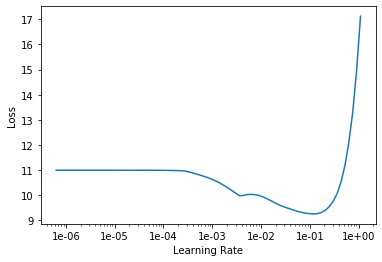

In [15]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [16]:
lr= 1e-3
learn.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.912467,3.755198,0.374601,1:44:01
1,3.525752,3.422811,0.409531,1:44:05
2,3.481450,3.325924,0.418845,1:44:03
3,3.379927,3.265353,0.425227,1:44:08
4,3.402357,3.215786,0.430605,1:44:06
5,3.308777,3.177339,0.435684,1:44:11
6,3.287405,3.133554,0.440952,1:44:18
7,3.286971,3.102202,0.445375,1:44:19
8,3.259800,3.079923,0.448275,1:44:16
9,3.184890,3.074348,0.449026,1:44:17


In [17]:
lm_fns

['vi_wt_bwd', 'vi_wt_vocab_bwd']

In [31]:
print(f'{learn.path}/{learn.model_dir}')

/home/projectx/Documents/Non-English sentiment analysis/viwiki/docs/models


In [18]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))

In [23]:
train_df = pd.read_csv('data/train.csv')
train_df.loc[pd.isna(train_df.comment),'comment']='NA'

test_df = pd.read_csv('data/test.csv')
test_df.loc[pd.isna(test_df.comment),'comment']='NA'
test_df['label'] = 0

df = pd.concat([train_df,test_df])

In [25]:
print(len(df))
df.head()

27068


,id,comment,label
0,train_000000,Dung dc sp tot cam on \nshop Đóng gói sản phẩm...,0
1,train_000001,Chất lượng sản phẩm tuyệt vời . Son mịn nhưng...,0
2,train_000002,Chất lượng sản phẩm tuyệt vời nhưng k có hộp ...,0
3,train_000003,:(( Mình hơi thất vọng 1 chút vì mình đã kỳ vọ...,1
4,train_000004,Lần trước mình mua áo gió màu hồng rất ok mà đ...,1


In [28]:
data_lm.

PosixPath('/home/projectx/Documents/Non-English sentiment analysis/viwiki')

In [35]:
data_lm = (TextList.from_df(df, path, cols='comment')
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1, backwards=True))

learn_lm = language_model_learner(data_lm, AWD_LSTM, config={**awd_lstm_lm_config, 'n_hid': 1152},
                                  pretrained_fnames=lm_fns, drop_mult=1.0)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


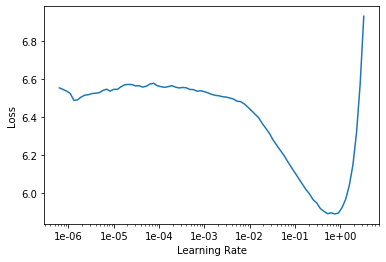

In [36]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [37]:
lr = 5e-2
learn_lm.fit_one_cycle(5, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.298134,3.955853,0.332359,00:13
1,4.183234,3.936702,0.337541,00:14
2,4.030202,3.839362,0.347741,00:14
3,3.857881,3.747446,0.355952,00:13
4,3.740221,3.726215,0.358415,00:13


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


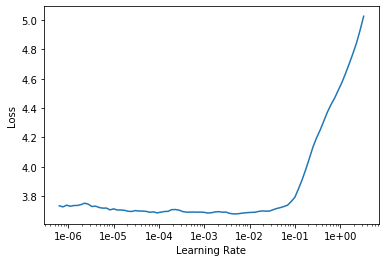

In [38]:
learn_lm.unfreeze()
learn_lm.lr_find()
learn_lm.recorder.plot()

In [39]:
lr = 8e-4
learn_lm.fit_one_cycle(7, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.638093,3.667025,0.364015,00:17
1,3.557601,3.593271,0.370969,00:17
2,3.438734,3.544390,0.377706,00:17
3,3.358260,3.516531,0.381318,00:17
4,3.286989,3.503150,0.384037,00:17
5,3.265308,3.499158,0.384794,00:17
6,3.231847,3.500547,0.384781,00:17


In [40]:
learn_lm.save(f'{lang}_fine_tuned_bwd')
learn_lm.save_encoder(f'{lang}_fine_tuned_enc_bwd')

In [63]:
data_clas = (TextList.from_df(train_df, path, vocab=data_lm.vocab, cols='comment')
    .split_by_rand_pct(0.1, seed=57)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=1, backwards=True))

data_clas.save(f'{lang}_textlist_class_bwd')

In [64]:
data_clas = load_data(path, f'{lang}_textlist_class_bwd', bs=bs, num_workers=1, backwards=True)

In [65]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [66]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.8, metrics=[accuracy, f1])
learn_c.load_encoder(f'{lang}_fine_tuned_enc_bwd')
learn_c.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


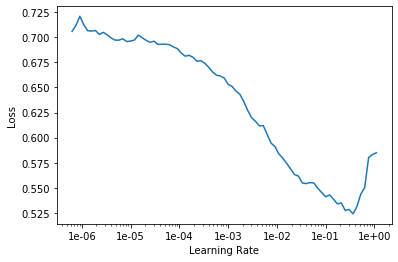

In [67]:
learn_c.lr_find()
learn_c.recorder.plot()

In [68]:
lr=5e-3
learn_c.fit_one_cycle(5, lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.392755,0.300886,0.861940,0.838368,00:08
1,0.375107,0.294552,0.868159,0.840589,00:07
2,0.337722,0.269921,0.884950,0.862927,00:07
3,0.338558,0.270636,0.886816,0.863257,00:07
4,0.336643,0.263912,0.893035,0.872518,00:07


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


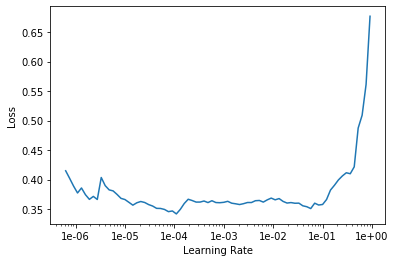

In [69]:
learn_c.freeze_to(-2)
learn_c.lr_find()
learn_c.recorder.plot()

In [70]:
lr = 1e-4
learn_c.fit_one_cycle(4,slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.333028,0.262011,0.893657,0.872064,00:09
1,0.337611,0.260832,0.895522,0.875241,00:09
2,0.318026,0.258183,0.889304,0.866982,00:09
3,0.334272,0.258892,0.888682,0.866774,00:09


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


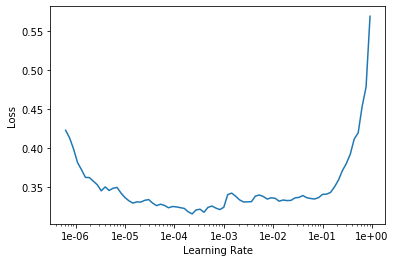

In [71]:
learn_c.freeze_to(-3)
learn_c.lr_find()
learn_c.recorder.plot()

In [72]:
lr = 1e-4
learn_c.fit_one_cycle(3,slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.330647,0.259593,0.886816,0.861396,00:14
1,0.317514,0.252054,0.895522,0.876233,00:13
2,0.331231,0.253305,0.897388,0.879478,00:13


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


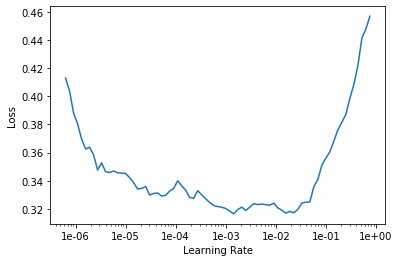

In [73]:
learn_c.unfreeze()
learn_c.lr_find()
learn_c.recorder.plot()

In [74]:
lr = 1e-5
learn_c.fit_one_cycle(2,slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.322755,0.251904,0.896766,0.877233,00:18
1,0.313361,0.249606,0.894901,0.875370,00:18


In [75]:
learn_c.save(f'{lang}_clas_bwd')